In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import time
import scipy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rcParams['figure.figsize'] = (8,8)
from sklearn import preprocessing

sns.set_style('white')
pd.set_option('display.max_columns', 35)

In [2]:
print "Starting to read in data..."
t1 = time.time()
requests = pd.read_csv('311__Service_Requests.csv', parse_dates=True)
t2 = time.time()
print "Read in data in %.2f seconds." % (t2 - t1)


Starting to read in data...


//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Read in data in 6.86 seconds.


In [3]:
# processing on the data types
print "Starting to process data types..."
t1 = time.time()
for col in ['OPEN_DT', 'TARGET_DT', 'CLOSED_DT']:
    requests[col] = pd.to_datetime(requests[col], infer_datetime_format=True)
t2= time.time()
print "Dates processed in %.2f seconds." % (t2-t1)

Starting to process data types...
Dates processed in 559.38 seconds.


In [83]:
begin = pd.to_datetime('January 1, 2015 12:01AM')
end = pd.to_datetime('December 31, 2015 11:59PM')

closed_requests = requests[requests['CASE_STATUS'] == 'Closed']
closed_requests = closed_requests[(closed_requests['Source']=='Constituent Call') | (closed_requests['Source']=='Citizens Connect App')]

in_range= closed_requests[closed_requests['OPEN_DT'] > begin]
in_range = in_range[in_range['OPEN_DT'] < end]

times = (in_range['CLOSED_DT'] - in_range['OPEN_DT']).astype('timedelta64[m]')

times_scaled = preprocessing.scale(times)
latitude_scaled = preprocessing.scale(in_range['LATITUDE'])
longitude_scaled = preprocessing.scale(in_range['LONGITUDE'])

times_scaled_call = times_scaled[np.where(in_range['Source']=='Constituent Call')]
lat_scaled_call = latitude_scaled[np.where(in_range['Source']=='Constituent Call')]
long_scaled_call = longitude_scaled[np.where(in_range['Source']=='Constituent Call')]

times_scaled_app = times_scaled[np.where(in_range['Source']=='Citizens Connect App')]
lat_scaled_app = latitude_scaled[np.where(in_range['Source']=='Citizens Connect App')]
long_scaled_app = longitude_scaled[np.where(in_range['Source']=='Citizens Connect App')]

print len(times_scaled_app)
print len(times_scaled_call)

appdata = np.stack((times_scaled_app, lat_scaled_app, long_scaled_app), axis = 1)
calldata = np.stack((times_scaled_call, lat_scaled_call, long_scaled_call), axis = 1)

np.random.shuffle(appdata)
appdata = appdata[::2]
print appdata.shape
np.random.shuffle(calldata)
calldata = calldata[::5]
print calldata.shape


36963
102102
(18482, 3)
(20421, 3)


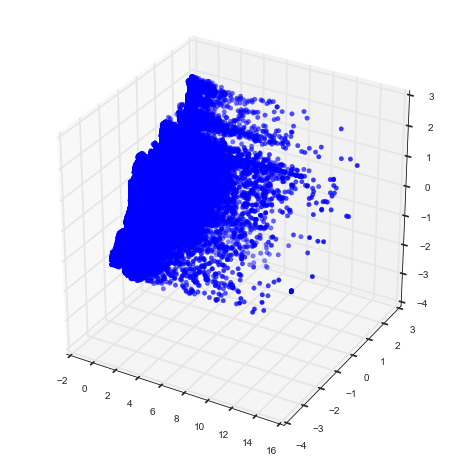

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(times_scaled, latitude_scaled, longitude_scaled, color = 'blue')
plt.show()

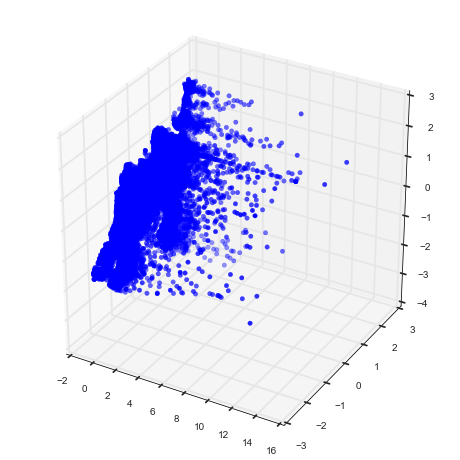

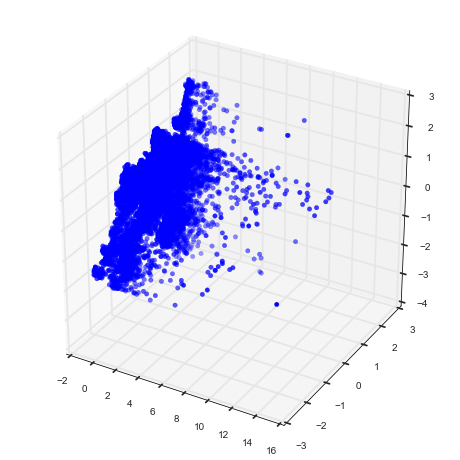

In [85]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(calldata[:,0], calldata[:,1], calldata[:,2], color = 'blue')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(appdata[:,0], appdata[:,1], appdata[:,2], color = 'blue')
plt.show()

In [109]:
from scipy.stats import invwishart, multivariate_normal, dirichlet

# It would be easier to debug if we implement each update separately
def update_Z(X, mu, Sigma, pi):
    """
    X: NxD matrix
    mu: Vector of k elements. Each element is a vector of D elements. 
    Sigma: Vector of k elements. Each element is a DxD covarianc ematrix
    pi: Vector of k scalars
    Returns Z, an NxK matrix made up of 1s and 0s (each row contains a single 1)
    """
    
    N = len(X)
    K = len(mu)
    Z = np.zeros((N,K))

    probs_vector = np.zeros(K)

    for i in range(N):
        for j in range(K):

            probs_vector[j] = pi[j]*multivariate_normal.pdf(X[i], mean = mu[j], cov = Sigma[j])
        normalization = np.sum(probs_vector)
        probs_vector = probs_vector/normalization
        Z[i] = np.random.multinomial(1, probs_vector)     
    
    return Z


def update_N_k(Z):
    """Returns a k-element vector describing number of elements in each cluster"""
    N_k = np.sum(Z, axis = 0)
    
    return N_k

def update_pi(alpha_k, Z):
    """
    alpha_k: Vector of K scalars
    Z: an NxK matrix
    pi: a vector of K scalars
    """
    N_k = np.sum(Z, axis = 0)
    pi = dirichlet.rvs(alpha_k+N_k)
    return np.squeeze(pi)

def update_mean_x_k(Z, X, N_k):
    """
    Average value of observations belonging to cluster k
    mean_x_k: Matrix of dimension KxD
    """
    mean_x_k = np.zeros((len(N_k),len(X[0])))
    for i in range(len(mean_x_k)):
        for j in range(len(Z)):
            mean_x_k[i]+=Z[j][i]*X[j]
        mean_x_k[i] = mean_x_k[i]/N_k[i]

    
    return mean_x_k


def update_nu_k(nu_0, N_k):
    """
    returns a k-element vector
    """

    nu_k = nu_0+N_k

    return nu_k



def update_V_k(V_0, N_k, Sigma_k):
    """
    V_0: DxD matrix
    N_k: Vector of k integers
    Sigma_k: Vector of k elements, each element is a DxD covariance matrix
    V_k: Vector of k elements, each element is a DxD covariance matrix
    """
    V_k = np.zeros_like(Sigma_k)
    V_0_inv = np.linalg.inv(V_0)
    for i in range(len(V_k)):
        inv = V_0_inv+N_k[i]*np.linalg.inv(Sigma_k[i])
        V_k[i] = np.linalg.inv(inv)             
        
    return V_k
    
def update_m_k(V_k, Sigma_k, N_k, mean_x_k, V_0, m_0):
    """
    V_0: DxD matrix
    m_0: Vector of K elements, each element has D elements
    N_k: Vector of k integers
    Sigma_k: Vector of k elements, each element is a DxD covariance matrix
    V_k: Vector of k elements, each element is a DxD covariance matrix
    mean_x_k: DxK matrix describing average values of observations in each cluster
    """
    V_0_inv = np.linalg.inv(V_0)
    m_k = np.zeros((len(N_k), len(m_0)))
    for i in range(len(m_k)):
        Sig_inv = np.linalg.inv(Sigma_k[i])

        m_k[i] = np.dot(V_k[i],(np.dot(Sig_inv,N_k[i]*mean_x_k[i])+np.dot(V_0_inv,m_0)))
    return m_k

def update_mu_k(m_k, V_k):
    """
    m_k: Vector of k elements, each element has a vector with D elements
    V_k: Vector of k elements, each element is a DxD covariance matrix
    mu_k: Vector of k elements, each element has a vector with D elements
    """
    mu_k = np.zeros_like(m_k)

    for i in range(len(mu_k)):
        mu_k[i] = multivariate_normal.rvs(mean = m_k[i], cov = V_k[i])

    return mu_k

def update_S_k(Z, X, mu_k, S_0):
    """
    S_0: DxD matrix
    Scale matrices for inverse wishart distribution
    Returns array of k matrices (DxD)
    """
    S_k = np.zeros((len(mu_k), S_0.shape[0], S_0.shape[1]))
    for j in range(len(mu_k)):
        S_k[j]=np.copy(S_0)
        for i in range(len(Z)):
            S_k[j]+=Z[i][j]*np.outer((X[i]-mu_k[j]),(X[i]-mu_k[j]))
    return S_k

def update_Sigma_k(S_k, nu_k):
    """
    Covariance matrices for the k clusters
    Returns array of k matrices of dimension DxD
    """
    Sigma_k = np.zeros_like(S_k)
    for i in range(len(nu_k)):
        Sigma_k[i] = invwishart.rvs(nu_k[i], S_k[i])
    return Sigma_k

# this function can be reused even when we change the prior on pi 
def gibbs_gmm(K, X, pi, Z, mu, Sigma, nu_0, S_0, V_0, m_0, alpha_0):
    """
    K: number of components
    X: observations
    nu_0: dof for inverse Wishart distribution
    S_0: scale matrix for inverse Wishart distribution
    m_0: Mean of normal-inverse-Wishart distribution
    V_0: Covariance matrix of normal-inverse-Wishart distribution
    alpha_0: parameter for Dirichlet distribution
    """
    numsamples = 200
    start = time.time()
    Z_samples = np.zeros((numsamples, Z.shape[0], Z.shape[1]))
    mu_samples = np.zeros((numsamples, mu.shape[0], mu.shape[1]))
    pi_samples = np.zeros((numsamples, K))
    Sigma_samples = np.zeros((numsamples, K, Sigma.shape[1], Sigma.shape[2]))
    nu_samples = np.zeros((numsamples, K))
    V_samples = np.zeros((numsamples, K, V_0.shape[0],V_0.shape[1]))
    m_samples = np.zeros((numsamples, K, m_0.shape[0]))
    S_samples = np.zeros_like(Sigma_samples)

    Z_samples[0] = Z
    N_k = update_N_k(Z_samples[0])
    pi_samples[0] = pi
    mean_x_k = update_mean_x_k(Z_samples[0], X, N_k)
    mu_samples[0] = mu
    Sigma_samples[0] = Sigma
    nu_samples[0] = update_nu_k(nu_0, N_k)
    V_samples[0] = update_V_k(V_0, N_k, Sigma_samples[0])
    m_samples[0] = update_m_k(V_samples[0], Sigma_samples[0], N_k, mean_x_k, V_0, m_0)
    print m_samples[0]
    S_samples[0] = update_S_k(Z_samples[0], X, mu_samples[0], S_0)

    for i in range(1,numsamples):
    
        Z_samples[i]= update_Z(X, mu_samples[i-1], Sigma_samples[i-1], pi_samples[i-1])
        N_k = update_N_k(Z_samples[i])
        #print "+++"
        #if i%20==0:
        #    print i, time.time()-start
        pi_samples[i] = update_pi(alpha_0, Z_samples[i])
        mean_x_k = update_mean_x_k(Z_samples[i], X, N_k)
        #if np.isnan(mean_x_k[0][0]) or np.isnan(mean_x_k[1][0]):
        #    print pi_samples[i-1], mu_samples[i-1], Sigma_samples[i-1], N_k
        mu_samples[i] = update_mu_k(m_samples[i-1], V_samples[i-1])
        Sigma_samples[i] = update_Sigma_k(S_samples[i-1], nu_samples[i-1])
        nu_samples[i] = update_nu_k(nu_0, N_k)
        V_samples[i]= update_V_k(V_0, N_k, Sigma_samples[i])
        m_samples[i] = update_m_k(V_samples[i], Sigma_samples[i], N_k, mean_x_k, V_0, m_0)
        S_samples[i] = update_S_k(Z_samples[i], X, mu_samples[i], S_0)

    return Z_samples, pi_samples, mu_samples, Sigma_samples, nu_samples, V_samples, m_samples, S_samples



In [110]:
K = 2
pi = np.array([0.9, 0.1])

Sigma = np.array([np.eye(3), np.eye(3)])

mu = np.array([[-0.2, 0,0],[3, 0,0]]) 
Z  = update_Z(appdata, mu, Sigma, pi)

nu_0 = 3
S_0 = np.eye(3)
V_0 =  np.eye(3)
m_0 = np.array([1., 1., 1.])  
alpha_0 = np.array([1., 1.])



Z_samples, pi_samples, mu_samples, Sigma_samples, nu_samples, V_samples, m_samples, S_samples= gibbs_gmm(K, 
                                                                                                         appdata, 
                                                                                                         pi, 
                                                                                                         Z, 
                                                                                                         mu, 
                                                                                                         Sigma, 
                                                                                                         nu_0, 
                                                                                                         S_0, 
                                                                                                         V_0, 
                                                                                                         m_0, 
                                                                                                         alpha_0)



[[-0.16065077  0.32100905  0.09672091]
 [ 3.50713211  0.34597902  0.04982218]]


In [111]:
burnin = 50

def get_mu_posterior(mu_samples, K, burnin):
    mu_avg = np.zeros_like(mu_samples[0])
    mu_std = np.zeros_like(mu_samples[0])
    for i in range(K):
        mu_avg[i] = np.mean(mu_samples[burnin:,i], axis = 0)
        mu_std[i] = np.std(mu_samples[burnin:,i], axis = 0)
    return mu_avg, mu_std

def get_pi_posterior(pi_samples, burnin):
    return np.mean(pi_samples[burnin:],axis = 0), np.std(pi_samples[burnin:], axis = 0)

def get_Sigma_posterior(Sigma_samples, burnin):
    return np.mean(Sigma_samples[burnin:],axis = 0), np.std(Sigma_samples[burnin:], axis = 0)

mu_avg, mu_std = get_mu_posterior(mu_samples, K, burnin)
pi_avg, pi_std = get_pi_posterior(pi_samples, burnin)
Sigma_avg, Sigma_std = get_Sigma_posterior(Sigma_samples, burnin)

[[-0.42718368  0.32612476  0.13721291]
 [ 0.57463859  0.31557202  0.03361904]]
[ 0.58809151  0.41190849]
[[[  1.32226722e-03  -2.22399368e-03  -1.93907652e-03]
  [ -2.22399368e-03   6.40663439e-01   2.84803706e-01]
  [ -1.93907652e-03   2.84803706e-01   9.05359162e-01]]

 [[  1.81406582e+00   3.24424979e-02   1.18573170e-02]
  [  3.24424979e-02   7.20657393e-01   3.12656525e-01]
  [  1.18573170e-02   3.12656525e-01   9.45779433e-01]]]


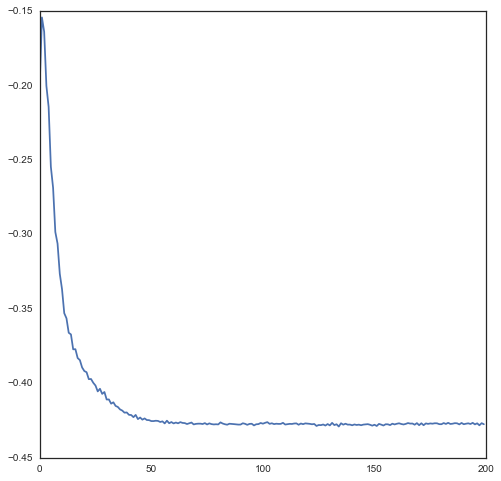

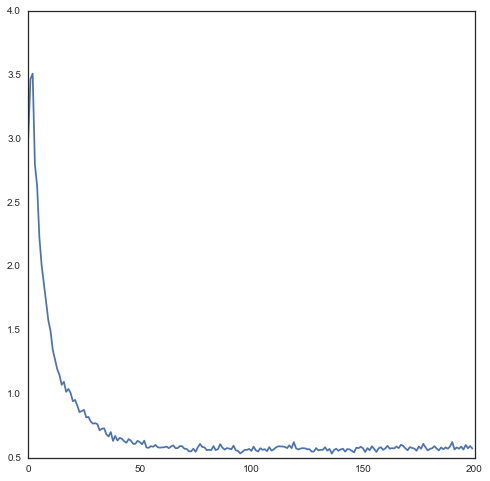

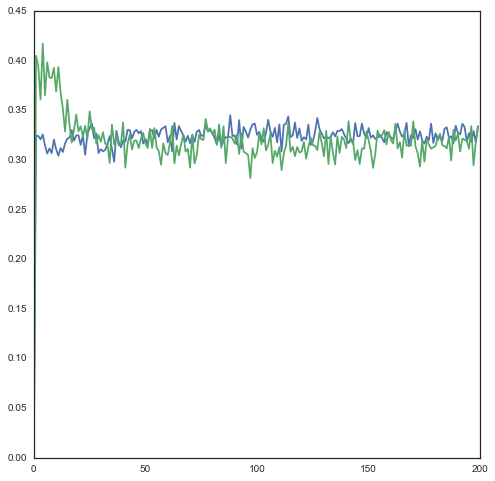

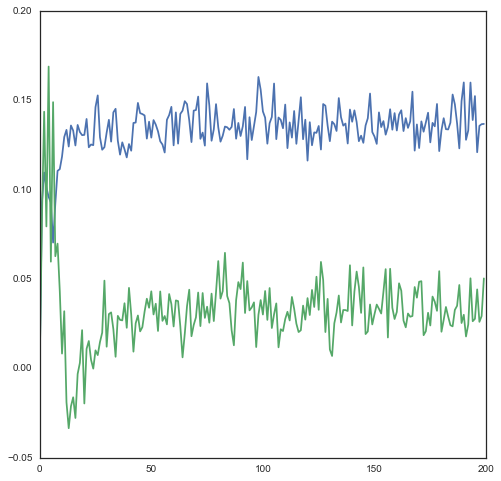

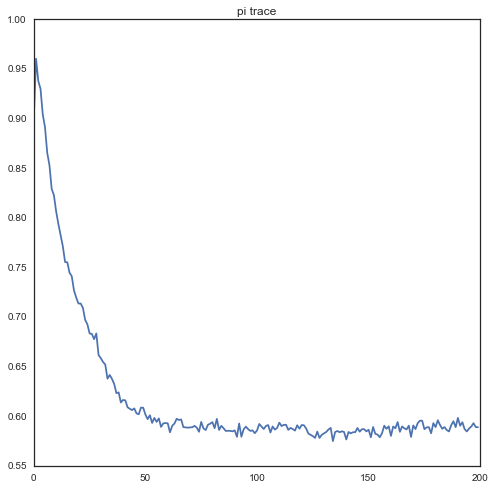

In [112]:
print mu_avg
print pi_avg
print Sigma_avg

plt.plot(mu_samples[:,0, 0])
plt.show()
plt.plot(mu_samples[:,1, 0])
plt.show()

plt.plot(mu_samples[:,0, 1])
plt.plot(mu_samples[:,1, 1])
plt.show()

plt.plot(mu_samples[:,0, 2])
plt.plot(mu_samples[:,1, 2])
plt.show()


plt.plot(pi_samples[:,0])
plt.title('pi trace')
plt.show()

#print mu_samples[burnin:,0].shape